In [ ]:
!pip install langchain langchain-groq langchain-community langchain-chroma
!pip install spacy networkx matplotlib python-louvain sentence-transformers chromadb
!python -m spacy download en_core_web_sm

In [ ]:
from google.colab import userdata
import os

GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader

loader = DirectoryLoader(
    "/content/Marie Curie",
    glob="*.txt",
    loader_cls=TextLoader
)
docs = loader.load()

all_texts = [doc.page_content for doc in docs]

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
all_entities = []
doc_entities = []

for i, text in enumerate(all_texts):
    doc = nlp(text)

    entities = [
        ent.text.strip()
        for ent in doc.ents
        if ent.label_ in ["PERSON", "ORG", "GPE", "LOC", "EVENT", "WORK_OF_ART"]
    ]
    doc_entities.append(entities)
    all_entities.extend(entities)

In [ ]:
import networkx as nx

G = nx.Graph()

for entities in doc_entities:
    unique_entities = list(set(entities))

    for entity in unique_entities:
        if not G.has_node(entity):
            G.add_node(entity, frequency=1)
        else:
            G.nodes[entity]['frequency'] += 1

    for i, entity1 in enumerate(unique_entities):
        for entity2 in unique_entities[i+1:]:
            if G.has_edge(entity1, entity2):
                G[entity1][entity2]['weight'] += 1
            else:
                G.add_edge(entity1, entity2, weight=1)

In [ ]:
from community import community_louvain

partition = community_louvain.best_partition(G)
num_communities = len(set(partition.values()))

In [ ]:
communities = {}
for entity, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(entity)

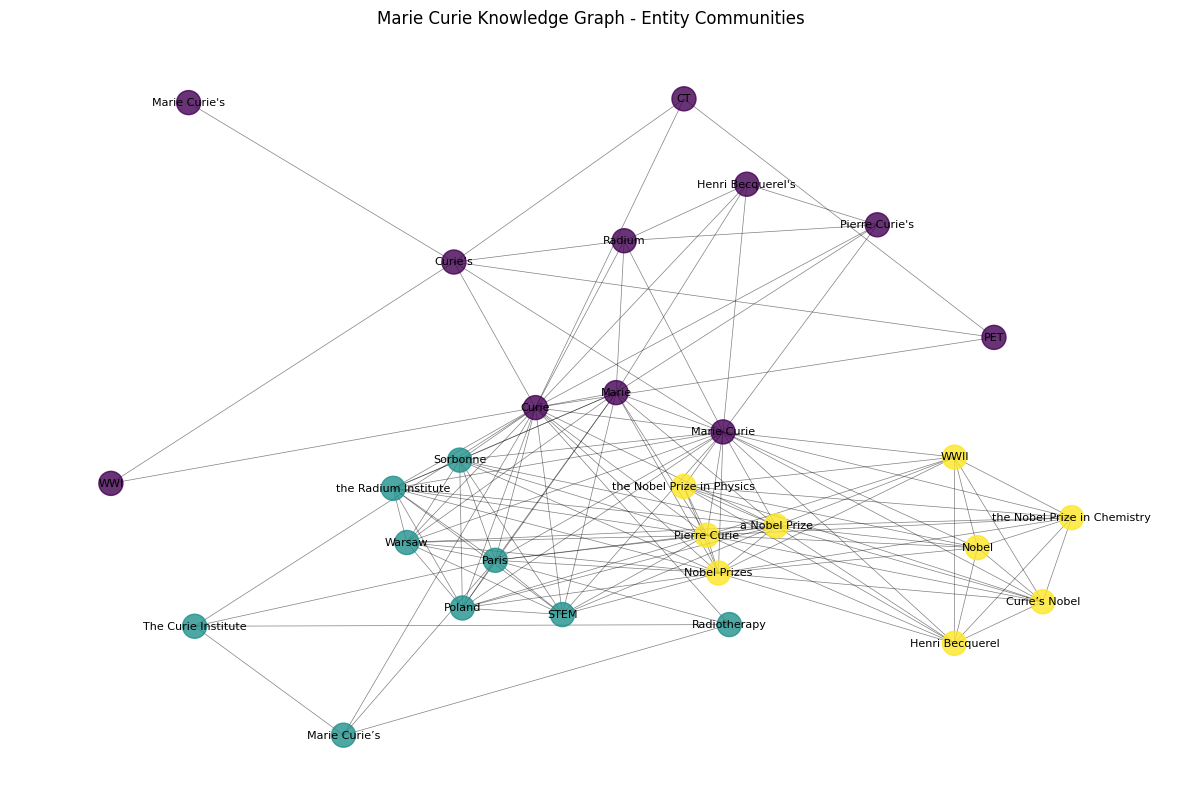

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=1, iterations=50)
colors = [partition[node] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Marie Curie Knowledge Graph - Entity Communities")
plt.axis('off')
plt.show()

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.3)

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

/tmp/ipython-input-1352497980.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from langchain.vectorstores.chroma import Chroma

vectorstore = Chroma(
    collection_name="marie_curie_kb",
    embedding_function=embeddings
)
vectorstore.add_documents(docs)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


['59badfdf-f7ca-437f-97cf-14435ec9b85d',
 '83920551-6cf8-4a72-a14e-4f5eb5d5de2a',
 '83866013-3e79-4d60-8275-252ae3b6e24c',
 '73831c25-6e25-4617-bdfb-9dcb7910c299',
 '9c2f4f36-b343-49b4-acdb-a8983da62321',
 '2e77f1a9-42cc-41da-8e7e-e374fe54a52f',
 '81f0f07b-56d7-4fa1-b37a-fb421f3268bb',
 'ddf0a8af-5495-47b6-89a9-99399bc77af1',
 'fd551cc0-e82b-48f5-bd5e-8c02ab256f58',
 '52f222e2-5829-42fe-bcfb-c93e415626a5']

In [ ]:
def find_shortest_path(entity1, entity2):
    """Find shortest path between two entities"""
    try:
        path = nx.shortest_path(G, source=entity1, target=entity2)
        return path
    except nx.NetworkXNoPath:
        return None

In [ ]:
def get_entity_neighbors(entity, max_neighbors=5):
    """Get neighboring entities for a given entity"""
    if entity in G:
        neighbors = list(G.neighbors(entity))
        # Sort by edge weight (connection strength)
        neighbors_with_weights = [
            (neighbor, G[entity][neighbor]['weight'])
            for neighbor in neighbors
        ]
        neighbors_with_weights.sort(key=lambda x: x[1], reverse=True)
        return neighbors_with_weights[:max_neighbors]
    return []

In [ ]:
def get_community_entities(entity):
    """Get all entities in the same community as given entity"""
    if entity in partition:
        community_id = partition[entity]
        return communities[community_id]
    return []

In [ ]:
def graph_rag_query(question):
    """Answer questions using graph structure and RAG"""

    relevant_docs = vectorstore.similarity_search(question, k=3)

    question_doc = nlp(question)
    question_entities = [
        ent.text.strip()
        for ent in question_doc.ents
        if ent.text.strip() in G.nodes()
    ]

    related_entities = set()
    for entity in question_entities:

        neighbors = get_entity_neighbors(entity)
        related_entities.update([n[0] for n in neighbors])

        community_members = get_community_entities(entity)
        related_entities.update(community_members[:5])

    doc_context = "\n".join([doc.page_content[:500] for doc in relevant_docs])
    graph_context = f"Related entities: {', '.join(list(related_entities)[:10])}"

    prompt = f"""
    Answer the following question using both the document context and entity relationships:

    Document Context:
    {doc_context}

    Graph Context (Related Entities):
    {graph_context}

    Question: {question}

    Answer:
    """

    response = llm.invoke(prompt)
    return response.content

In [ ]:
def community_summary(community_id):
    """Generate summary for a specific community"""
    if community_id in communities:
        entities = communities[community_id]
        context = f"Entity community contains: {', '.join(entities)}"

        prompt = f"""
        Analyze this group of related entities and provide a summary of what they represent:

        {context}

        Summary:
        """

        response = llm.invoke(prompt)
        return response.content
    return "Community not found"

In [ ]:
questions = [
    "What was Marie Curie's most important discovery?",
    "Tell me about radioactivity research",
    "What awards did Marie Curie receive?"
]

for question in questions:
    print(f"\nQuestion: {question}")
    answer = graph_rag_query(question)
    print(f"Answer: {answer}")
    print('-' *200)


Question: What was Marie Curie's most important discovery?
Answer: Marie Curie's most important discovery was the isolation of radium and polonium, which led to a deeper understanding of radioactivity and transformed the field of chemistry. Her discovery proved that atoms could emit energy, challenging the long-standing belief that atoms were indivisible, and paved the way for significant advancements in nuclear reactions, isotopic studies, and the periodic table. This discovery is considered one of her most important contributions to science, earning her the Nobel Prize in Chemistry in 1911 and cementing her legacy as a pioneering figure in the history of science.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question: Tell me about radioactivity research
Answer: Radioactivity research began with the discovery of spontaneous radia

In [ ]:
for comm_id in list(communities.keys())[:3]:
    print(f"\n🏘️ Community {comm_id} Summary:")
    summary = community_summary(comm_id)
    print(summary)


🏘️ Community 0 Summary:
The entity community appears to represent the concept of "Radioactivity" and its related historical figures, discoveries, and applications. 

The key entities in this group include:

1. Radium: A radioactive element discovered by Marie Curie.
2. Marie Curie: A pioneering physicist and chemist who discovered the elements polonium and radium, and was the first woman to win a Nobel Prize.
3. CT (Computed Tomography) and PET (Positron Emission Tomography): Medical imaging technologies that utilize radioactive isotopes to produce images of the body.
4. Pierre Curie: Marie Curie's husband and collaborator, who also contributed to the discovery of radioactivity.
5. Henri Becquerel: A French physicist who first discovered radioactivity in 1896, paving the way for the Curies' research.
6. WWI: World War I, during which Marie Curie developed mobile X-ray units to treat wounded soldiers, utilizing her knowledge of radioactivity.

The presence of these entities together su

In [ ]:
entity_list = list(G.nodes())[:10]
if len(entity_list) >= 2:
    entity1, entity2 = entity_list[0], entity_list[1]
    path = find_shortest_path(entity1, entity2)
    print(f"\n Path from '{entity1}' to '{entity2}': {path}")


🛤️ Path from 'Radium' to 'Marie Curie': ['Radium', 'Marie Curie']


In [ ]:
sample_entity = entity_list[0] if entity_list else None
if sample_entity:
    neighbors = get_entity_neighbors(sample_entity)
    print(f"\n🔗 '{sample_entity}' is connected to:")
    for neighbor, weight in neighbors:
        print(f"  - {neighbor} (strength: {weight})")


🔗 'Radium' is connected to:
  - Marie Curie (strength: 2)
  - Curie (strength: 2)
  - Marie (strength: 1)
  - Pierre Curie's (strength: 1)
  - Henri Becquerel's (strength: 1)
